<a href="https://www.kaggle.com/barzcan/turkish-airlines-stock-price-prediction-with-rnn?scriptVersionId=88413904" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/turkish-airlines-daily-stock-prices-since-2013/cleanThy.csv


In [18]:
dataset=pd.read_csv('/kaggle/input/turkish-airlines-daily-stock-prices-since-2013/cleanThy.csv')
dataset=dataset[::-1] #Inverting Dataset
dataset.reset_index(inplace=True)
dataset.drop(['index'],axis=1,inplace=True)
dataset.head(5)

,Date,Last Price,Lowest Price,Highest Price,Volume
0,26 Temmuz 2013,8.12,8.06,8.28,173415145
1,29 Temmuz 2013,8.10,8.08,8.20,89525203
2,30 Temmuz 2013,8.22,8.12,8.26,95139613
3,31 Temmuz 2013,8.16,8.10,8.26,88391549
4,01 Ağustos 2013,8.10,8.10,8.24,86225217


In [19]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1502 non-null   object 
 1    Last Price     1502 non-null   float64
 2    Lowest Price   1502 non-null   float64
 3    Highest Price  1502 non-null   float64
 4    Volume         1502 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 58.8+ KB


# Graphs

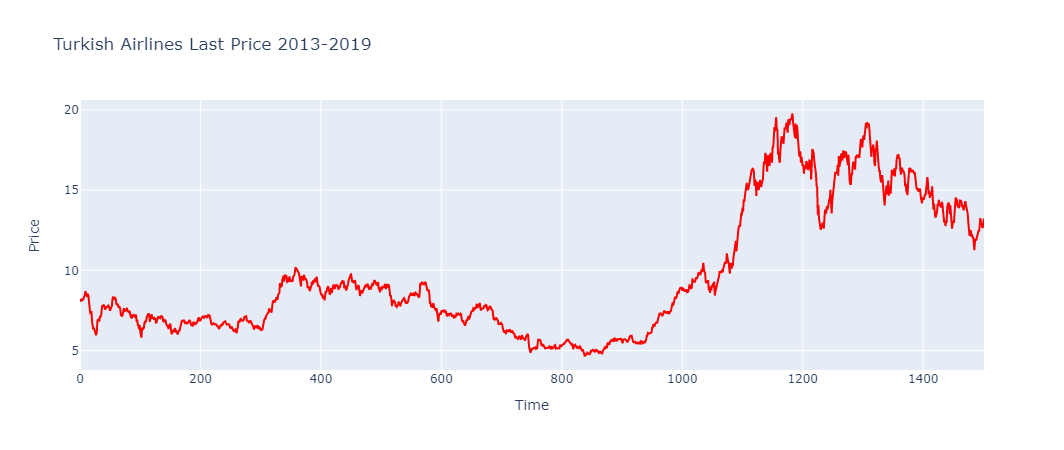

In [20]:
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import plotly.graph_objects as go
trace=go.Scatter(x=dataset.index, y=dataset.iloc[:,1],
                    mode='lines',
                    name='Last Price',
                    marker = dict(color = 'red'))
layout = dict(title = 'Turkish Airlines Last Price 2013-2019',
              xaxis= dict(title= 'Time'),
              yaxis=dict(title='Price')
             )
fig = dict(data = trace, layout = layout)

iplot(fig)

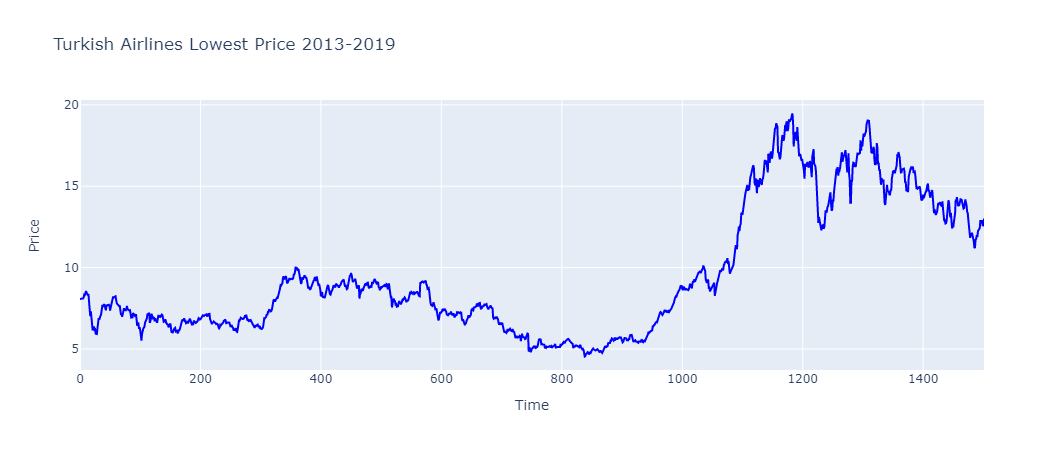

In [21]:
from plotly.offline import iplot
import plotly.graph_objects as go
trace=go.Scatter(x=dataset.index, y=dataset.iloc[:,2],
                    mode='lines',
                    name='Lowest Price',
                    marker = dict(color = 'blue'))
layout = dict(title = 'Turkish Airlines Lowest Price 2013-2019',
              xaxis= dict(title= 'Time'),
              yaxis=dict(title='Price')
             )
fig = dict(data = trace, layout = layout)

iplot(fig)

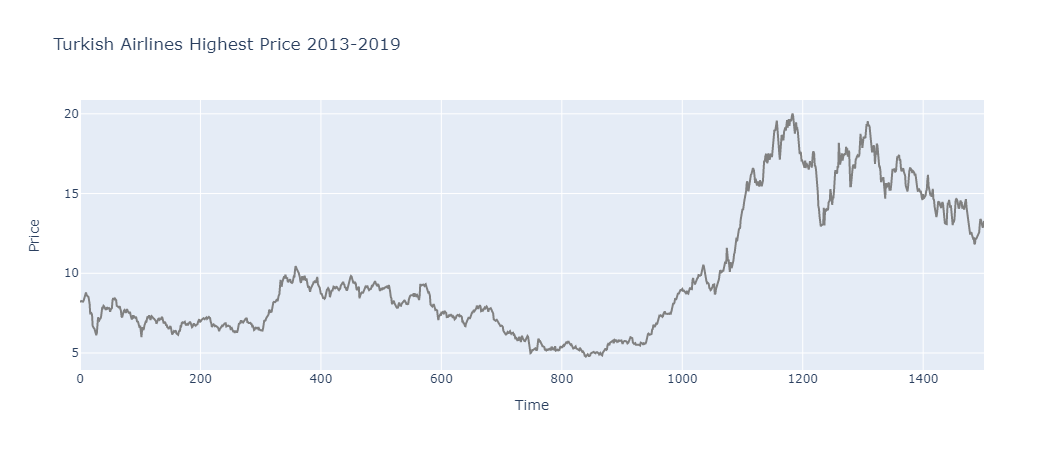

In [22]:
from plotly.offline import iplot
import plotly.graph_objects as go
trace=go.Scatter(x=dataset.index, y=dataset.iloc[:,3],
                    mode='lines',
                    name='Highest Price',
                    marker = dict(color = 'grey'))
layout = dict(title = 'Turkish Airlines Highest Price 2013-2019',
              xaxis= dict(title= 'Time'),
              yaxis=dict(title='Price')
             )
fig = dict(data = trace, layout = layout)

iplot(fig)

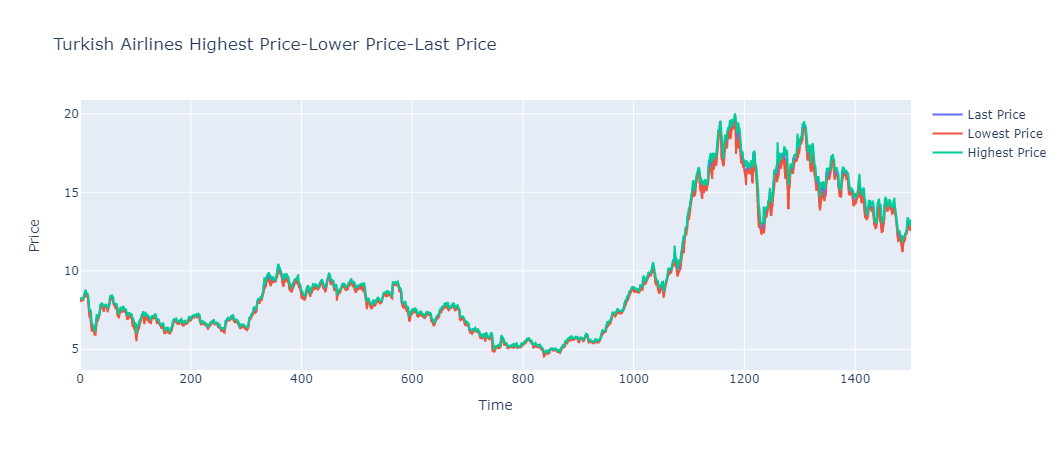

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:,1],
                    mode='lines',
                    name='Last Price'))
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:,2],
                    mode='lines',
                    name='Lowest Price'))
fig.add_trace(go.Scatter(x=dataset.index, y=dataset.iloc[:,3],
                    mode='lines',
                    name='Highest Price'))
fig.update_layout(title='Turkish Airlines Highest Price-Lower Price-Last Price',
                  xaxis_title='Time',
                  yaxis_title='Price')

iplot(fig)

# Splitting Dataset

## Timestep=80 days, Test Set=100 days

In [24]:
training_set=dataset.iloc[0:1402,1:2].values
test_set = dataset.iloc[1322:,1:2].values #Last 100+80 days because of timestep

The model will try to predict the last 100 days of Last Stock Price

In [25]:
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=[0,1])
training_set_scaled=sc.fit_transform(training_set)

In [26]:
#Creating a data structure with 60 timesteps and 1 Output
X_train=[]
y_train=[]

for i in range(80,len(training_set_scaled)): 
    X_train.append(training_set_scaled[i-80:i,0])
    y_train.append(training_set_scaled[i,0]) 

X_train,y_train=np.array(X_train),np.array(y_train)

#Reshaping
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1)) #3 Dimension

# Building RNN

In [27]:
## Step 2 Building RNN,

#Importing the Keras Library
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

#Initialising the RNN
regressor = Sequential()

#Adding LSTM layers Dropout regularisation
regressor.add(LSTM(units=55,return_sequences=True,input_shape = (X_train.shape[1], 1))) 

regressor.add(Dropout(rate=0.15)) #Dropout Regularization

regressor.add(LSTM(units=55,return_sequences=True))
regressor.add(Dropout(rate=0.15))

regressor.add(LSTM(units=55,return_sequences=True))
regressor.add(Dropout(rate=0.15))

regressor.add(LSTM(units=55))
regressor.add(Dropout(rate=0.15))

#Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 80, 55)            12540     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80, 55)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 80, 55)            24420     
_________________________________________________________________
dropout_5 (Dropout)          (None, 80, 55)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 80, 55)            24420     
_________________________________________________________________
dropout_6 (Dropout)          (None, 80, 55)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 55)               

In [28]:
# Fitting the RNN
regressor.fit(X_train,y_train, epochs = 64,batch_size=20)

Epoch 1/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0142
Epoch 2/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0052
Epoch 3/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0051
Epoch 4/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0038
Epoch 5/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0036
Epoch 6/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0040
Epoch 7/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0029
Epoch 8/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0026
Epoch 9/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 10/64
67/67 [==============================] - 1s 16ms/step - loss: 0.0028
Epoch 11/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0028
Epoch 12/64
67/67 [==============================] - 1s 15ms/step - loss: 0.0022
Epoch 13/64
67/67 [==================

# Testing and Results

Let's test our model with the last 100 days of Last Stock Price

In [29]:
inputs=sc.transform(test_set)
X_test=list()
for i in range(80,180):
    X_test.append(inputs[i-80:i, 0])



X_test=np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_stock_price=regressor.predict(X_test)
predicted_stock_price=sc.inverse_transform(predicted_stock_price)

In [30]:
real_stock_price=dataset.iloc[1402:,1:2]
real_stock_price.reset_index(inplace=True)
real_stock_price.drop(['index'],axis=1,inplace=True)
real_stock_price=real_stock_price.values

total_data=np.concatenate((real_stock_price, predicted_stock_price), axis=1)
total_data=pd.DataFrame(data=total_data,columns=['Real Stock Price','Predicted Stock Price'])
total_data

,Real Stock Price,Predicted Stock Price
0,14.69,14.405775
1,14.76,14.518414
2,14.67,14.640695
3,15.06,14.680870
4,15.20,14.812720
...,...,...
95,12.95,13.083453
96,12.65,13.055467
97,12.68,12.885759
98,13.02,12.723169


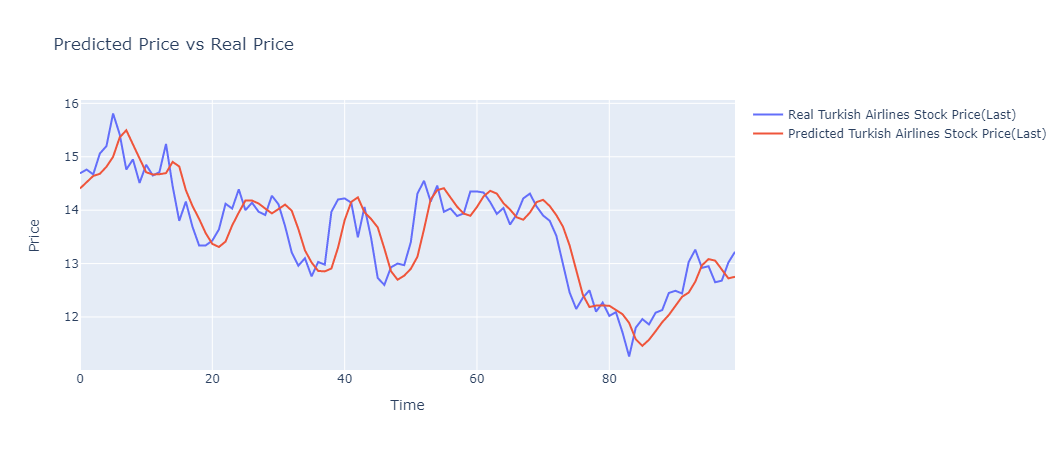

In [31]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=total_data.index, y=total_data['Real Stock Price'],
                    mode='lines',
                    name='Real Turkish Airlines Stock Price(Last)'))
fig.add_trace(go.Scatter(x=total_data.index, y=total_data['Predicted Stock Price'],
                    mode='lines',
                    name='Predicted Turkish Airlines Stock Price(Last)'))
fig.update_layout(title='Predicted Price vs Real Price',
                  xaxis_title='Time',
                  yaxis_title='Price')

iplot(fig)

In [32]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,r2_score

print('MAE=%0.2f'%mean_absolute_error(real_stock_price,predicted_stock_price))
print('MSE=%0.2f'%mean_squared_error(real_stock_price,predicted_stock_price))
print('MedAE=%0.2f'%median_absolute_error(real_stock_price,predicted_stock_price))
print('RMSE=%0.2f'%np.sqrt(mean_squared_error(real_stock_price,predicted_stock_price)))
print('R2 Score=%0.2f'%r2_score(real_stock_price,predicted_stock_price))

MAE=0.35
MSE=0.19
MedAE=0.29
RMSE=0.44
R2 Score=0.79
